In [3]:
"""
Database exists: Nights spent at tourist accommodation establishments by degree of urbanisation (from 2012 onwards) (tour_occ_ninatd)
Weather data?:
    https://climate.copernicus.eu/monthly-summaries-precipitation-relative-humidity-and-soil-moisture
    https://climate.copernicus.eu/node/74
"""
pass

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from data_management import load_tsv
from data_utils import string_encoding_to_datetime, select_by_dict, get_df_with_split_time, print_unique_values
from datetime import datetime
plt.rcParams['figure.figsize'] = 20, 16

In [10]:
class FeatureExclusionManager(object):
    def __init__(self):
        self.store_loc = "data_store/excluded_features.txt"
        self.delimiter = ":::"
    
    def get(self):
        with open(self.store_loc, "r") as file:
            excluded = file.read().split(self.delimiter)
        return excluded
    
    def save(self, additions):
        new_list = self.get() + additions
        new_list = list(set(new_list))
        
        with open(self.store_loc, "w") as file:
            file.write(self.delimiter.join(new_list))
FEM = FeatureExclusionManager()

In [13]:
YEAR_BOUNDS = (1998, 2018)
PREDICTION_TIME_SCALE = "month"
def extrapolate_time(inp_df, kind=PREDICTION_TIME_SCALE, year_bounds = YEAR_BOUNDS):
    def __sub(sub_df):
        df = sub_df.copy()
        df.drop_duplicates(inplace=True, keep = "last", subset=[col for col in df.columns if col != "value"])
        df["time"] = df["time"].apply(string_encoding_to_datetime)

        if kind == "year":
            indices = [datetime(y, 1, 1) for y in range(YEAR_BOUNDS[0], YEAR_BOUNDS[1]+1)]
        elif kind == "month":
            indices = [
                datetime(y, m, 1) for y in range(YEAR_BOUNDS[0], YEAR_BOUNDS[1]+1) for m in range (1,12+1)
            ]

        res = pd.DataFrame(columns = df.columns)
        res = res.set_index("time")
        for geo in df["geo"].unique():
            interpolated = pd.DataFrame(df[df["geo"] == geo].set_index("time"), index=indices)
            interpolated = interpolated.interpolate(method='time', limit_direction="both")
            interpolated["geo"] = geo
            res = res.append(interpolated)
        return res.rename_axis('time').reset_index()
    extra_columns = [col for col in inp_df.columns if col not in ["time", "geo", "value"]]
    if len(extra_columns) == 0:
        return __sub(inp_df)
    else:
        res = pd.DataFrame(columns = inp_df.columns)
        groups = inp_df.groupby(extra_columns)
        for group in groups.groups:
            temp = __sub(groups.get_group(group))
            for col in extra_columns:
                temp[col] = group[col] if len(extra_columns) > 1 else group
            res.append(temp)
        return temp
        
# extrapolate_time(select_by_dict(lan_settl, {
#     "unit": "Percentage"
# }), "month")
# extrapolate_time(lan_settl, "month")

"""
Inputs format:
    dict_of_parameters = {
            "name": {
                "source": dataframe,
                "fields": {
                    "name": [list of accepted values] OR expected value OR "ALL" OR "ALL - somthing"
                },
                "fillna": value #Optional
        },
    The other inputs are the same as extrapolate_time
    If feature in the the list of excluded features, it is ignored
"""
def join_and_extrapolate_values_from_multiple_sources(dict_of_parameters, kind=PREDICTION_TIME_SCALE, year_bounds = YEAR_BOUNDS):
    final_df = None
    excluded_features = FEM.get()
    
    for name, df_parameters in dict_of_parameters.items():
        source = df_parameters["source"]
        fields_parameters = df_parameters["fields"]
        
        # Filter only to wanted values
        for field_name, accepted_values in fields_parameters.items():
            if isinstance(accepted_values, list):
                source = source[source[field_name].isin(accepted_values)]
            elif accepted_values == "ALL":
                continue
            elif accepted_values.startswith("ALL - "):
                rejected_value = accepted_values.replace("ALL - ", "")
                source = source[source[field_name] != rejected_value] 
            else:
                source = source[source[field_name] == accepted_values]
        
        unqiue_field_combinations = source[fields_parameters.keys()].drop_duplicates()
        for index, row in unqiue_field_combinations.iterrows():
            identifier = name + ": " + "; ".join([str(r) for r in row.values])
            filtered_df = select_by_dict(source, row.to_dict())
            filtered_df = extrapolate_time(filtered_df, kind, year_bounds)
            filtered_df = filtered_df.set_index(["geo", "time"])
            
            if final_df is None:
                final_df = pd.DataFrame(index=filtered_df.index)
            final_df[identifier] = filtered_df["value"]
    
    fillna_dict = {}
    for name, df_parameters in dict_of_parameters.items():
        fillna = df_parameters.get("fillna", None)
        if fillna is not None:
            for col in [col for col in final_df.columns if col.startswith(name + ": ")]:
                fillna_dict[col] = fillna
    
    final_df = final_df.fillna(fillna_dict)
    final_df = final_df[[col for col in final_df.columns if col not in excluded_features]]
    return final_df

In [7]:
"""
Feature databases
Land cover overview by NUTS 2 regions (lan_lcv_ovw)
Settlement area (lan_settl)
Distribution of population aged 18 and over by health status, age group, sex and degree of urbanisation - EU-SILC survey (ilc_lvhl01)
Mean and median income by degree of urbanisation (ilc_di17)
Persons working as creative and performing artists, authors, journalists and linguists by individual and employment characteristics (cult_emp_artpc)
General government expenditure by function (COFOG) (gov_10a_exp)
    NOTE: THIS ONE IS BIG
Prisoners by age and sex - number and rate for the relevant sex and age groups (crim_pris_age)
Purchasing power adjusted GDP per capita (sdg_10_10+ESTAT)
HICP (2015 = 100) - monthly data (index) (prc_hicp_midx)
Education indicators by NUTS 2 regions (educ_regind)

"""
tour_occ_nim = load_tsv("tour_occ_nim.tsv", decode=True)
lan_lcv_ovw = load_tsv("lan_lcv_ovw.tsv", decode=True)
lan_settl = load_tsv("lan_settl.tsv", decode=True)
ilc_lvhl01 = load_tsv("ilc_lvhl01.tsv", decode=True)
ilc_di17 = load_tsv("ilc_di17.tsv", decode=True)
cult_emp_artpc = load_tsv("cult_emp_artpc.tsv", decode=True)
# gov_10a_exp = load_tsv("gov_10a_exp.tsv", decode=True) # Too big
crim_pris_age = load_tsv("crim_pris_age.tsv", decode=True)
sdg_10_10 = load_tsv("sdg_10_10+ESTAT.tsv", decode=True)
prc_hicp_midx = load_tsv("prc_hicp_midx.tsv", decode=True)
educ_regind = load_tsv("educ_regind.tsv", decode=True)

# Regional has too many regions
lan_lcv_ovw = lan_lcv_ovw[lan_lcv_ovw["geo"].isin(lan_settl["geo"])]
educ_regind = educ_regind[educ_regind["geo"].isin(lan_settl["geo"])]

In [8]:
print_unique_values(prc_hicp_midx)

unit
	Index, 2005=100
	Index, 2015=100
	Index, 1996=100
coicop
	All-items HICP
	Food and non-alcoholic beverages
	Food
	Bread and cereals
	Rice
	Flours and other cereals
	Bread
	Other bakery products
	Pizza and quiche
	Pasta products and couscous
	Breakfast cereals
	Other cereal products
	Meat
	Beef and veal
	Pork
	Lamb and goat
	Poultry
	Other meats
	Edible offal
	Dried, salted or smoked meat
	Other meat preparations
	Fish and seafood
	Fresh or chilled fish
	Frozen fish
	Fresh or chilled seafood
	Frozen seafood
	Dried, smoked or salted fish and seafood
	Other preserved or processed fish and seafood and fish and seafood preparations
	Milk, cheese and eggs
	Fresh whole milk
	Fresh low fat milk
	Preserved milk
	Yoghurt
	Cheese and curd
	Other milk products
	Eggs
	Oils and fats
	Butter
	Margarine and other vegetable fats
	Olive oil
	Other edible oils
	Other edible animal fats
	Fruit
	Fresh or chilled fruit
	Frozen fruit
	Dried fruit and nuts
	Preserved fruit and fruit-based products
	Vege

In [15]:
temp = join_and_extrapolate_values_from_multiple_sources({
#     "nights_stayed": {
#         "source": tour_occ_nim,
#         "fields": {
#             "c_resid": "ALL - Total",
#             "unit": "ALL",
#             "nace_r2": "ALL",
#         },
#         "fillna": 0
#     },
    "land_cover" : {
        "source": lan_lcv_ovw,
        "fields": {
            "unit": "ALL",
            "landcover": "ALL",
        },
        "fillna": 0
    },
    "set_area" : {
        "source": lan_settl,
        "fields": {
            "unit": ["Square metres per capita", "Percentage", "Square kilometre"],
        },
        "fillna": 0
    },
    "pop_over_18" : {
        "source": ilc_lvhl01,
        "fields": {
            "deg_urb": "ALL - Total",
            "levels": "ALL",
            "age": "ALL",
            "sex": "ALL"
        },
        "fillna": 0
    },
    "income" : {
        "source": ilc_di17,
        "fields": {
            "unit": "Euro",
            "indic_il": "ALL",
            "deg_urb": "ALL",
            "sex": ["Females", "Males"],
            "age": "ALL"
        },
        "fillna": 0
    },
    "cultural_employment" : {
        "source": cult_emp_artpc,
        "fields": {
            "isco08": "ALL",
            "ind_type": "ALL",
            "unit": "Percentage",
        },
        "fillna": 0
    },
    "prisioners" : {
        "source": crim_pris_age,
        "fields": {
            "age": "ALL",
            "sex": "ALL",
            "unit": "Per hundred thousand inhabitants",
        },
        "fillna": 0
    },
    "Purchasing_power" : {
        "source": sdg_10_10,
        "fields": {
            "freq": "Annual",
            "na_item": "ALL",
            "unit": "Percentage",
            "ppp_cat": "Gross domestic product",
        },
        "fillna": 0
    },
    "Education" : {
        "source": educ_regind,
        "fields": {
            "indic_ed": "ALL",
        },
        "fillna": 0
    },
    "Price_of_goods" : {
        "source": prc_hicp_midx,
        "fields": {
            "unit": "ALL",
            "coicop": "ALL",
        },
        "fillna": 0
    },
})
print(temp.loc[("Austria", "2000-01-01")])

land_cover: Coefficient of variation for absolute value; Greenhouses                                                 0.0
land_cover: Coefficient of variation for absolute value; Triticale                                                  14.2
land_cover: Coefficient of variation for absolute value; Other non permanent industrial crops                       45.9
land_cover: Coefficient of variation for absolute value; Other fresh vegetables                                     39.2
land_cover: Coefficient of variation for absolute value; Oranges                                                     0.0
                                                                                                                   ...  
Price_of_goods: Index, 1996=100; Passenger transport by air                                                          0.0
Price_of_goods: Index, 1996=100; Passenger transport by sea                                                          0.0
Price_of_goods: Index, 1996=100;

In [16]:
temp.reset_index()["geo"].unique()

array(['Austria', 'Belgium', 'Bulgaria', 'Cyprus', 'Czechia',
       'Germany (until 1990 former territory of the FRG)', 'Denmark',
       'Estonia', 'Greece', 'Spain',
       'European Union - 27 countries (2007-2013)',
       'European Union - 28 countries',
       'European Union (aggregate changing according to the context)',
       'Finland', 'France', 'Croatia', 'Hungary', 'Ireland', 'Italy',
       'Lithuania', 'Luxembourg', 'Latvia', 'Malta', 'Netherlands',
       'Poland', 'Portugal', 'Romania', 'Sweden', 'Slovenia', 'Slovakia',
       'United Kingdom'], dtype=object)

In [17]:
"""
Get weather data
Monthly temperture and precipitation is assumed to be fairly constant
"""
weather_df = pd.read_csv("data_store/climate.tsv", sep="\t", index_col=0)
weather_df["time"] = weather_df["time"].apply(string_encoding_to_datetime)
weather_df = weather_df.drop("month", axis=1)
weather_df = weather_df.rename(columns={"country": "geo"})
weather_df = weather_df.set_index(["geo", "time"])
weather_df
temp = pd.merge(weather_df, temp, left_index=True, right_index=True)
x = temp
x

tas         pr  \
geo      time                               
Poland   1999-05-01  11.291688  67.545786   
Czechia  2018-02-01  -1.317235  59.453862   
Hungary  2017-06-01  17.246167  88.292434   
Latvia   2014-07-01  16.866671  53.570647   
Portugal 2009-07-01  20.835044  18.390166   
...                        ...        ...   
         2009-05-01  15.519680  38.991772   
Croatia  2000-01-01   2.073433  74.186102   
Hungary  1998-06-01  17.246167  88.292434   
France   2009-06-01  16.338389  61.644601   
Austria  1998-07-01  17.779759  91.037073   

                     land_cover: Coefficient of variation for absolute value; Greenhouses  \
geo      time                                                                               
Poland   1999-05-01                                          46.600000                      
Czechia  2018-02-01                                          54.800000                      
Hungary  2017-06-01                                          80.000000                      
Latvia   2014-07-01                                         150.100000                      
Portugal 2009-07-01                                          56.124749                      
...                                                                ...                      
         2009-05-01                                          56.453425                      
Croatia  2000-01-01                                         129.000000                      
Hungary  1998-06-01                                          93.800000                      
France   2009-06-01                                          50.986575                      
Austria  1998-07-01                                           0.000000                      

                     land_cover: Coefficient of variation for absolute value; Triticale  \
geo      time                                                                             
Poland   1999-05-01                                           3.100000                    
Czechia  2018-02-01                                          39.900000                    
Hungary  2017-06-01                                          11.200000                    
Latvia   2014-07-01                                          30.856204                    
Portugal 2009-07-01                                          41.743562                    
...                                                                ...                    
         2009-05-01                                          43.515068                    
Croatia  2000-01-01                                          67.100000                    
Hungary  1998-06-01                                          10.700000                    
France   2009-06-01                                           9.024201                    
Austria  1998-07-01                                          14.200000                    

                     land_cover: Coefficient of variation for absolute value; Other non permanent industrial crops  \
geo      time                                                                                                        
Poland   1999-05-01                                          33.500000                                               
Czechia  2018-02-01                                          26.500000                                               
Hungary  2017-06-01                                          47.200000                                               
Latvia   2014-07-01                                          94.263504                                               
Portugal 2009-07-01                                          85.100000                                               
...                                                                ...                                               
         2009-05-01                                          85.100000                                 

c_resid
	Foreign country
	Reporting country
	Total
unit
	Number
	Percentage change compared to same period in previous year
nace_r2
	Hotels and similar accommodation
	Hotels; holiday and other short-stay accommodation; camping grounds, recreational vehicle parks and trailer parks
	Holiday and other short-stay accommodation
	Holiday and other short-stay accommodation; camping grounds, recreational vehicle parks and trailer parks
	Camping grounds, recreational vehicle parks and trailer parks
geo
	Albania
	Austria
	Belgium
	Bulgaria
	Switzerland
	Cyprus
	Czechia
	Germany (until 1990 former territory of the FRG)
	Denmark
	Euro area (EA11-2000, EA12-2006, EA13-2007, EA15-2008, EA16-2010, EA17-2013, EA18-2014, EA19)
	Estonia
	Greece
	Spain
	European Union - 27 countries (2007-2013)
	European Union - 28 countries
	Finland
	France
	Croatia
	Hungary
	Ireland
	Iceland
	Italy
	Liechtenstein
	Lithuania
	Luxembourg
	Latvia
	Montenegro
	North Macedonia
	Malta
	Netherlands
	Norway
	Poland
	Portugal
	

C:\Users\tonym\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


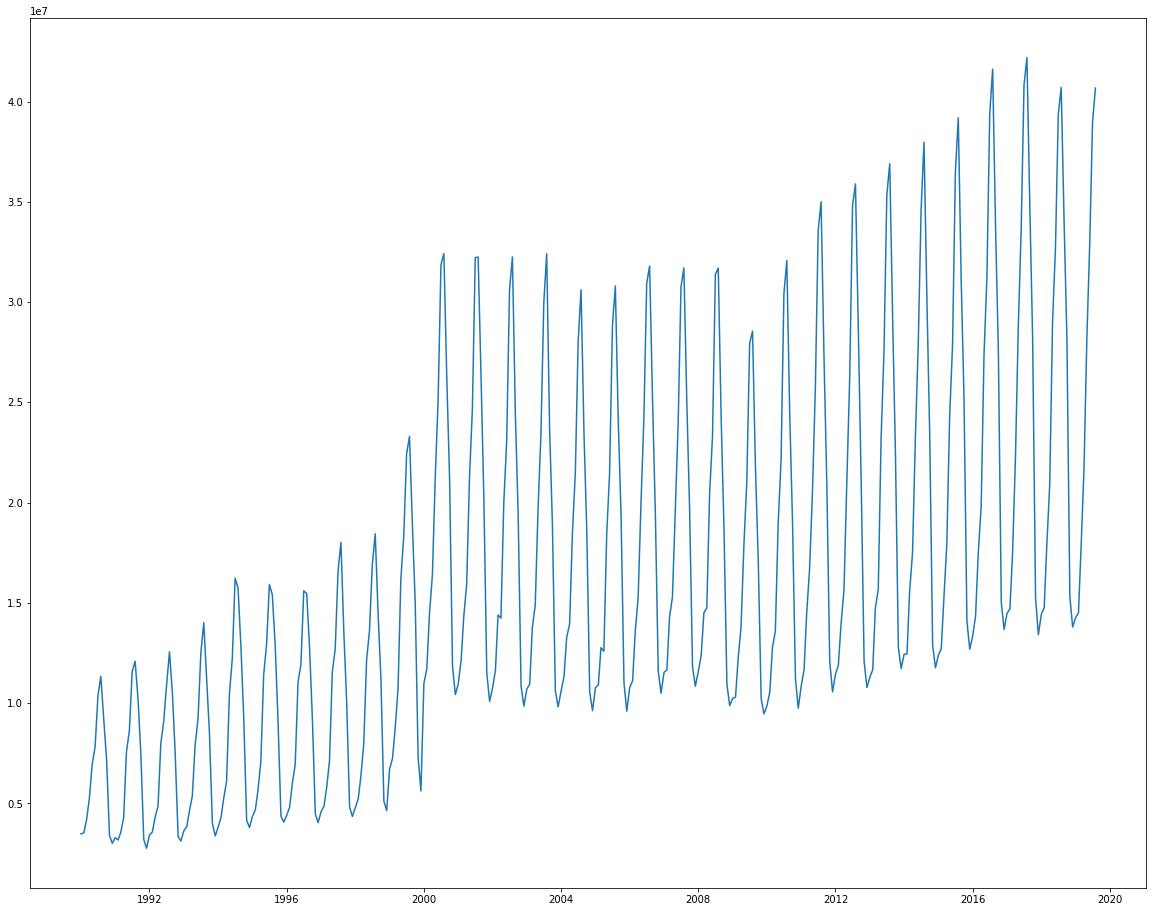

In [18]:
"""
What is being predicted on
"""
# Employment numbers
# tour_lfsq1r2 = load_tsv("tour_lfsq1r2.tsv", decode=True)
# print_unique_values(tour_lfsq1r2)
# y = select_by_dict(tour_lfsq1r2, {
#     "nace_r2": "Total - all NACE activities",
#     "wstatus": "Employees",
#     "worktime": "Part-time",
#     "unit": "Thousand",
# })
# y["time"] = y["time"].apply(string_encoding_to_datetime)
# y = y.dropna(axis=0, subset=["value"])
# y = y.set_index(["geo", "time"])
# plt.plot(y.xs("Spain", level="geo", drop_level=True).sort_index())

# Hotel stays
tour_occ_nim = load_tsv("tour_occ_nim.tsv", decode=True)
print_unique_values(tour_occ_nim)
y = select_by_dict(tour_occ_nim, {
    "c_resid": "Foreign country",
    "unit": "Number",
    "nace_r2": "Hotels; holiday and other short-stay accommodation; camping grounds, recreational vehicle parks and trailer parks",
})
# y["value"] = y["value"] / y.groupby(['geo', "year"])["value"].transform(np.sum)
y["time"] = y["time"].apply(string_encoding_to_datetime)
y = y.dropna(axis=0, subset=["value"])
y = y.set_index(["geo", "time"])
plt.plot(y.xs("Spain", level="geo", drop_level=True).sort_index())
y = y["value"]

In [28]:
y.index.get_level_values("time")

DatetimeIndex(['2019-12-01', '2019-12-01', '2019-12-01', '2019-11-01',
               '2019-11-01', '2019-11-01', '2019-10-01', '2019-10-01',
               '2019-10-01', '2019-10-01',
               ...
               '1990-01-01', '1990-01-01', '1990-01-01', '1990-01-01',
               '1990-01-01', '1990-01-01', '1990-01-01', '1990-01-01',
               '1990-01-01', '1990-01-01'],
              dtype='datetime64[ns]', name='time', length=9624, freq=None)

In [39]:
YEAR_CUTOFF = datetime(2017, 1, 1)
def get_test_set():
    return x.iloc[x.index.get_level_values("time") >= YEAR_CUTOFF, :], y[y.index.get_level_values("time") >= YEAR_CUTOFF]
def get_train_set():
    return x.iloc[x.index.get_level_values("time") < YEAR_CUTOFF, :], y[y.index.get_level_values("time") < YEAR_CUTOFF]
get_test_set()[1]

geo                                                                                            time      
Euro area (EA11-2000, EA12-2006, EA13-2007, EA15-2008, EA16-2010, EA17-2013, EA18-2014, EA19)  2019-12-01    50289864.0
European Union - 27 countries (2007-2013)                                                      2019-12-01    64664863.0
European Union - 28 countries                                                                  2019-12-01    65160780.0
Euro area (EA11-2000, EA12-2006, EA13-2007, EA15-2008, EA16-2010, EA17-2013, EA18-2014, EA19)  2019-11-01    47407604.0
European Union - 27 countries (2007-2013)                                                      2019-11-01    64225379.0
                                                                                                                ...    
Sweden                                                                                         2017-01-01      618141.0
Slovenia                                              

In [19]:
from model_wrappers import NormalizingRegressionModel, SampleFilteringRegressionModel, ColumnFilteringRegressionModel
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression

In [71]:
regressor = MLPRegressor(hidden_layer_sizes=(100, 50, 10), activation='relu', max_iter=5000, solver='adam')
# regressor = LinearRegression()
regressor = ColumnFilteringRegressionModel(regressor)
regressor = NormalizingRegressionModel(
    regressor,
    "scale"
)
regressor = SampleFilteringRegressionModel(regressor)
regressor.fit(x, y)

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(100, 50, 10), learning_rate='constant',
             learning_rate_init=0.001, max_iter=5000, momentum=0.9,
             n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
             random_state=None, shuffle=True, solver='adam', tol=0.0001,
             validation_fraction=0.1, verbose=False, warm_start=False)

In [160]:
"""
Plot results
"""
from data_utils import adjust_lightness
def plot_prediction_results_by_country(countries, figsize):
    cx, cy = get_test_set()
    plt.figure(figsize=figsize)
    for country in countries:
        ty = cy.xs(country, level="geo", drop_level=False)
        common_index = ty.index.intersection(x.index).sort_values()
        ty = ty.loc[common_index]
        p = plt.plot(regressor.predict(cx.loc[common_index, :]).droplevel(0), 
                     label=country.split(" ")[0]+"_Pred")
        p = plt.plot(ty.droplevel(0), label=country.split(" ")[0]+"_True",
                 color = adjust_lightness(p[0].get_color(), 1.5))
    plt.legend()
    plt.ylabel("Number of overnight stays by foreigners")
    plt.xlabel("Month")
    plt.title("Forcasted vs True Number of Overnight Stays in {0}".format(", ".join([
        country.split(" ")[0] for country in countries])))
    plt.show()

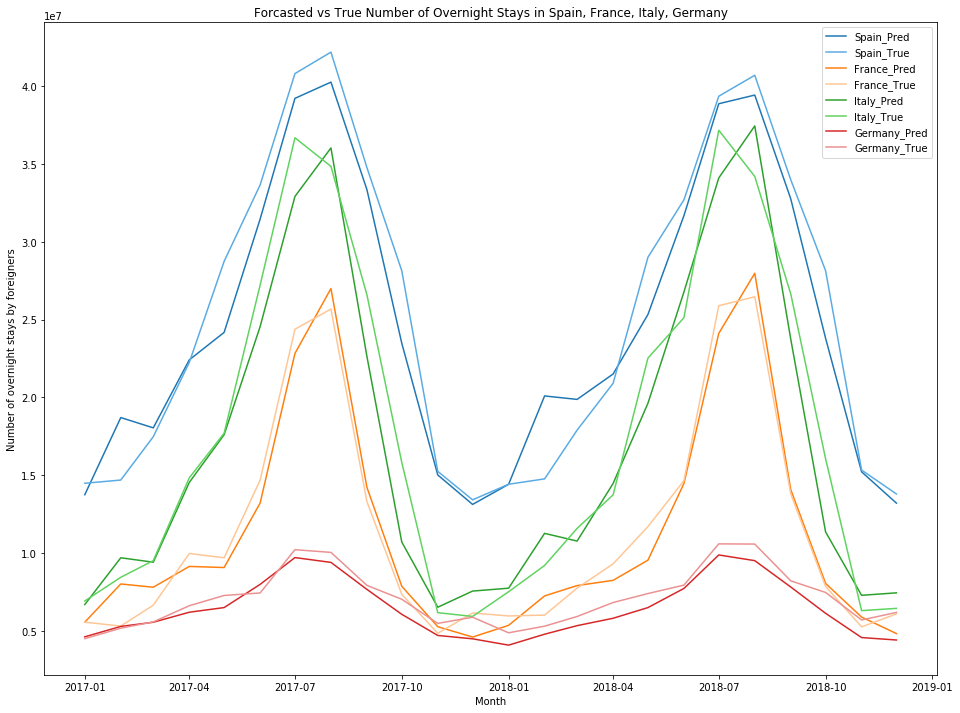

In [161]:
plot_prediction_results_by_country(["Spain", "France", "Italy", "Germany (until 1990 former territory of the FRG)"], figsize=(16, 12))

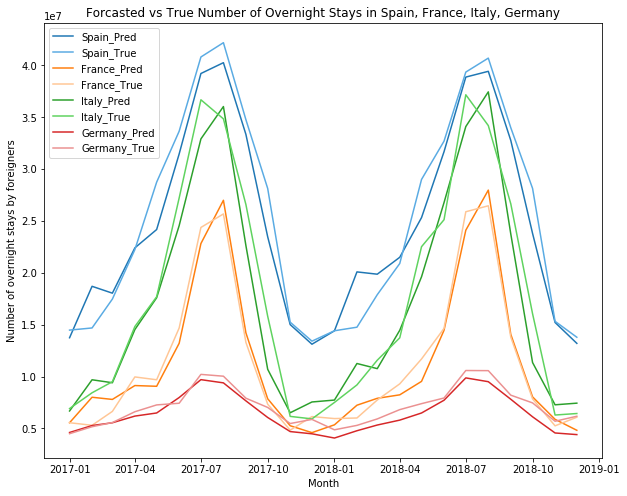

In [162]:
plot_prediction_results_by_country(["Spain", "France", "Italy", "Germany (until 1990 former territory of the FRG)"], figsize=(10, 8))

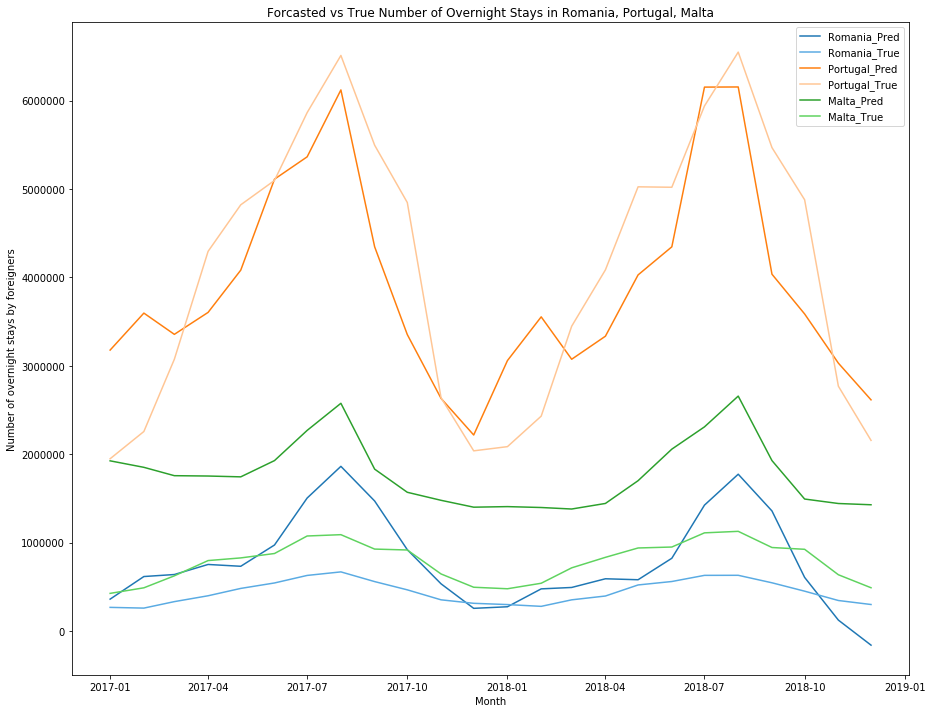

In [167]:
plot_prediction_results_by_country(["Romania", "Portugal", "Malta"], figsize=(15, 12))

In [72]:
from feature_selection import get_features_by_score, forwards_recursive_feature_selection
from feature_selection import FeatureScoringFunctions, ModelScoringFunctions
ss = get_features_by_score(
    regressor, x, y,
    FeatureScoringFunctions.get_permutation_score(ModelScoringFunctions.internal_score)
)
for fs in ss:
    print("{1:.5f} {0}".format(fs[0], fs[1]))

0.77461 pr
0.77891 tas
0.81843 Price_of_goods: Index, 2015=100; Toasters and grills
0.84998 land_cover: Square kilometre; Dry pulses, vegetables and flowers
0.87662 land_cover: Square kilometre; Apple fruit
0.89424 Price_of_goods: Index, 2015=100; Wine from other fruits
0.91985 Price_of_goods: Index, 1996=100; Major durables for indoor and outdoor recreation including musical instruments
0.92350 land_cover: Coefficient of variation for absolute value; Triticale
0.92489 Price_of_goods: Index, 2015=100; Services related to package holidays and accommodation
0.92676 Price_of_goods: Index, 2015=100; Coal
0.92867 land_cover: Square kilometre; Non built-up linear features
0.92946 pop_over_18: Rural areas; Very good; 18 years or over; Total
0.93019 pop_over_18: Rural areas; Bad; 65 years or over; Total
0.93133 Price_of_goods: Index, 2005=100; Combined passenger transport
0.93167 Education: Participation rates of 4-years-olds in education at regional level
0.93213 land_cover: Square kilometre;

In [ ]:
def create_model():
    regressor = MLPRegressor(hidden_layer_sizes=(100, 50, 10), activation='relu', max_iter=5000, solver='adam')
    # regressor = LinearRegression()
    regressor = NormalizingRegressionModel(
        regressor,
        "scale"
    )
    regressor = ColumnFilteringRegressionModel(regressor)
    regressor = SampleFilteringRegressionModel(regressor)
    return regressor

In [143]:
def plot_prediction_with_features(country, list_of_features, model_creation_function, figsize):
    cx, cy = get_test_set()
    cy = cy.xs(country, level="geo", drop_level=False)
    plt.figure(figsize=figsize)
    for i in range(1, len(list_of_features)+1):
        nx = cx.loc[:, list_of_features[:i]]
        ty = cy
        common_index = ty.index.intersection(nx.index).sort_values()
        ty = cy.loc[common_index]
        regressor = model_creation_function()
        regressor.fit(nx, y)
        plt.plot(regressor.predict(nx.loc[common_index, :]).droplevel(0), label="{0} features".format(i))
    real = cy.droplevel("geo")
    real = real[real.index < datetime(2019,1,1)]
    plt.plot(real, label="Actual", color="black")
    plt.xlabel("Time")
    plt.ylabel("Number of Overnight Stays")
    plt.title("Prediction results with n features, for {0}".format(country))
    plt.legend()
    plt.show()

def print_correlation_of_features_to_y(country, list_of_features):
    for feature in list_of_features:
        ty = y.xs(country, level="geo", drop_level=False)
        common_index = ty.index.intersection(x.index).sort_values()
        ty = ty.loc[common_index]
        tx = x.loc[common_index, :]
        print("{0} {1}".format(
            tx.loc[:, feature].corr(ty),
            feature
        ))

def plot_prediction_variation(country, model_creation_function, count, figsize):
    cx, cy = get_test_set()
    cy = cy.xs(country, level="geo", drop_level=False)
    plt.figure(figsize=figsize)
    for i in range(1, count + 1):
        nx = cx
        ty = cy
        common_index = ty.index.intersection(nx.index).sort_values()
        ty = cy.loc[common_index]
        regressor = model_creation_function()
        regressor.fit(nx, y)
        plt.plot(regressor.predict(nx.loc[common_index, :]).droplevel(0), label="Run {0}".format(i))
    
    real = cy.droplevel("geo")
    real = real[real.index < datetime(2019,1,1)]
    plt.plot(real, label="Actual", color="black", linewidth=3)
    plt.xlabel("Time")
    plt.ylabel("Number of Overnight Stays")
    plt.title("Variation in Prediction Results for {0}".format(country))
    plt.legend()
    plt.show()
    

features_of_interest = [
    "land_cover: Square kilometre; Buildings with more than 3 floors",
    "tas",
    "Price_of_goods: Index, 1996=100; Cultural services",
    "Price_of_goods: Index, 2015=100; Passenger transport by sea and inland waterway",
    "Price_of_goods: Index, 2015=100; Services related to package holidays and accommodation",
    "pop_over_18: Rural areas; Good; 65 years or over; Females",
    "prisioners: Adult; Total; Per hundred thousand inhabitants"
    ]



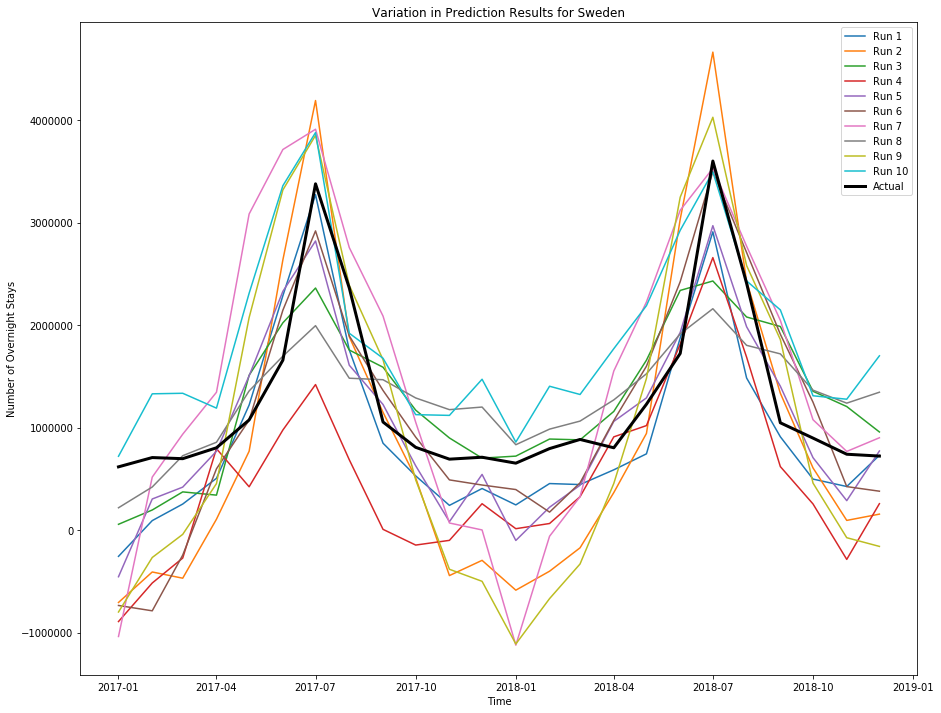

In [171]:
plot_prediction_variation("Sweden", create_model, 10, figsize=(15, 12))

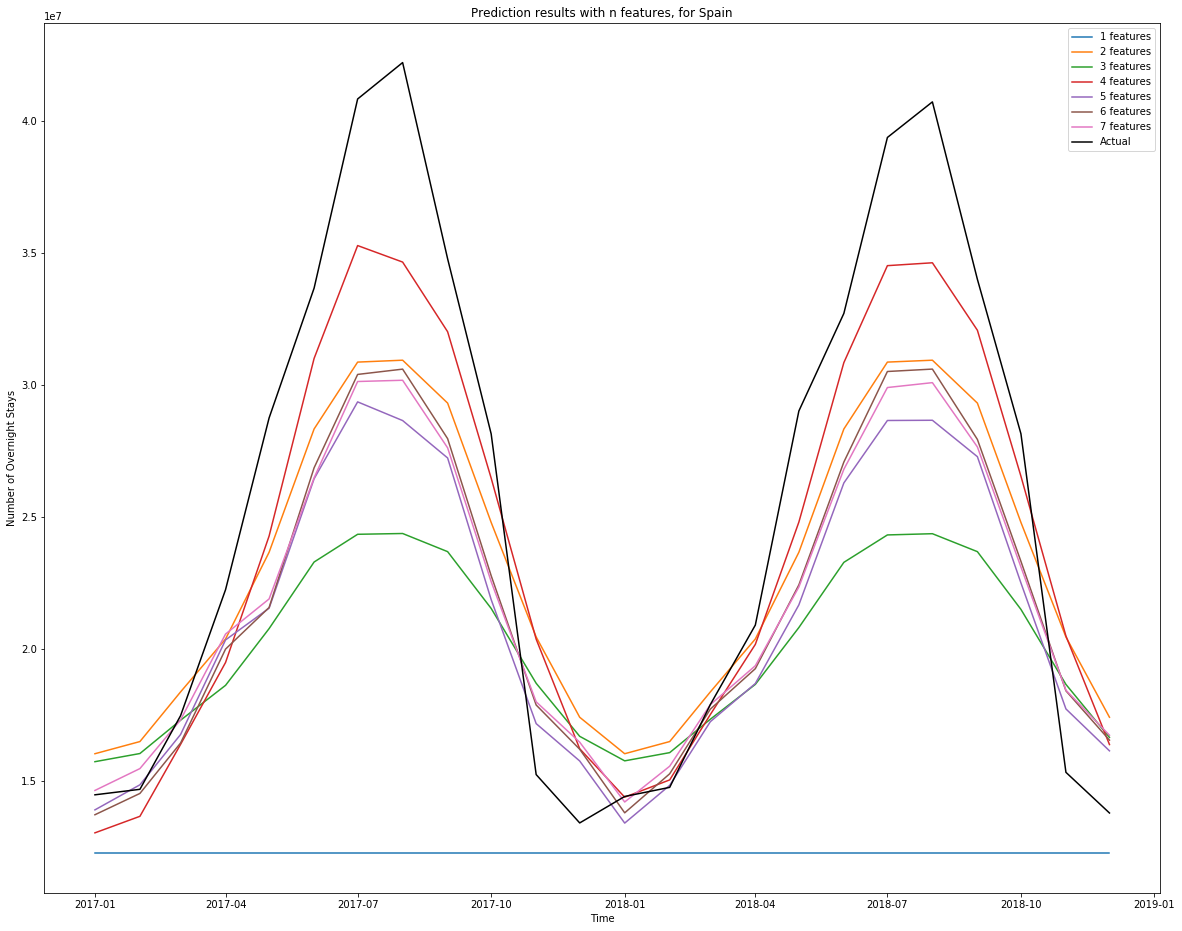

In [130]:
plot_prediction_with_features("Spain", features_of_interest, create_model, figsize=(20, 16))

In [119]:
print_correlation_of_features_to_y("Spain", features_of_interest)
print_correlation_of_features_to_y("Spain", [
    "land_cover: Percentage; Soya",
    "pr",
    "land_cover: Coefficient of variation for absolute value; Other citrus fruit",
    "Price_of_goods: Index, 2005=100; Combined passenger transport",
    "land_cover: Percentage; Lucerne",
    "pop_over_18: Cities; Bad; 65 years or over; Total",
    "Price_of_goods: Index, 2015=100; Wine from other fruits"
])

0.3144786697248015 land_cover: Square kilometre; Buildings with more than 3 floors
0.8833604848303025 tas
0.3252808532195167 Price_of_goods: Index, 1996=100; Cultural services
0.2924680728394257 Price_of_goods: Index, 2015=100; Passenger transport by sea and inland waterway
0.6152667747472517 Price_of_goods: Index, 2015=100; Services related to package holidays and accommodation
0.305923679093511 pop_over_18: Rural areas; Good; 65 years or over; Females
-0.3325766248702168 prisioners: Adult; Total; Per hundred thousand inhabitants
nan land_cover: Percentage; Soya
-0.8543898841593659 pr
0.2539571875643743 land_cover: Coefficient of variation for absolute value; Other citrus fruit
0.3052584610624011 Price_of_goods: Index, 2005=100; Combined passenger transport
0.29733908624873545 land_cover: Percentage; Lucerne
-0.28345040054180476 pop_over_18: Cities; Bad; 65 years or over; Total
nan Price_of_goods: Index, 2015=100; Wine from other fruits


In [69]:
fbs = forwards_recursive_feature_selection(
    create_model,
    x,
    y,
    ModelScoringFunctions.internal_score,
    stop_after=20,
    minimize=False
)

Selected land_cover: Square kilometre; Buildings with more than 3 floors
Selected tas
Selected pop_over_18: Rural areas; Good; 65 years or over; Females
Selected land_cover: Percentage; Soya
Selected pop_over_18: Cities; Bad; 18 years or over; Total
Selected Price_of_goods: Index, 2015=100; Passenger transport by sea and inland waterway
Selected Price_of_goods: Index, 2015=100; Services related to package holidays and accommodation
Selected prisioners: Adult; Total; Per hundred thousand inhabitants
Selected pr
Selected land_cover: Coefficient of variation for absolute value; Other citrus fruit
Selected Price_of_goods: Index, 2005=100; Combined passenger transport
Selected income: Euro; Median equivalised net income; Rural areas; Males; 18 years or over
Selected land_cover: Percentage; Lucerne
Selected Price_of_goods: Index, 2015=100; Coal
Selected pop_over_18: Cities; Bad; 65 years or over; Total
Selected Price_of_goods: Index, 2015=100; Wine from other fruits
Selected Price_of_goods: 

In [172]:
for fs in fbs:
    print("{1:.5f} {0}".format(fs[0], fs[1]))

0.57029 land_cover: Square kilometre; Buildings with more than 3 floors
0.77696 tas
0.86945 pop_over_18: Rural areas; Good; 65 years or over; Females
0.90709 land_cover: Percentage; Soya
0.92537 pop_over_18: Cities; Bad; 18 years or over; Total
0.94101 Price_of_goods: Index, 2015=100; Passenger transport by sea and inland waterway
0.94692 Price_of_goods: Index, 2015=100; Services related to package holidays and accommodation
0.94802 prisioners: Adult; Total; Per hundred thousand inhabitants
0.95226 pr
0.95481 land_cover: Coefficient of variation for absolute value; Other citrus fruit
0.95824 Price_of_goods: Index, 2005=100; Combined passenger transport
0.96107 income: Euro; Median equivalised net income; Rural areas; Males; 18 years or over
0.96010 land_cover: Percentage; Lucerne
0.95973 Price_of_goods: Index, 2015=100; Coal
0.96407 pop_over_18: Cities; Bad; 65 years or over; Total
0.96102 Price_of_goods: Index, 2015=100; Wine from other fruits
0.96130 Price_of_goods: Index, 2005=100; 

In [70]:
combined = set()
combined.update([x[0] for x in fbs])
combined.update([x[0] for x in ss][:30])
exclude = [col for col in x.columns if col not in combined]
exclude

['land_cover: Coefficient of variation for absolute value; Greenhouses',
 'land_cover: Coefficient of variation for absolute value; Other non permanent industrial crops',
 'land_cover: Coefficient of variation for absolute value; Other fresh vegetables',
 'land_cover: Coefficient of variation for absolute value; Oranges',
 'land_cover: Coefficient of variation for absolute value; Salt-marshes',
 'land_cover: Coefficient of variation for absolute value; Salines',
 'land_cover: Square kilometre; Common wheat',
 'land_cover: Square kilometre; Other root crops',
 'land_cover: Square kilometre; Cherry fruit',
 'land_cover: Square kilometre; Salines',
 'land_cover: Percentage; Wetland',
 'pop_over_18: Cities; Bad; From 18 to 64 years; Females',
 'pop_over_18: Cities; Bad; From 18 to 64 years; Total',
 'pop_over_18: Cities; Fair; From 18 to 64 years; Total',
 'pop_over_18: Cities; Fair; 18 years or over; Total',
 'pop_over_18: Cities; Good; From 18 to 64 years; Total',
 'pop_over_18: Cities; 

In [39]:
FEM.save(exclude)

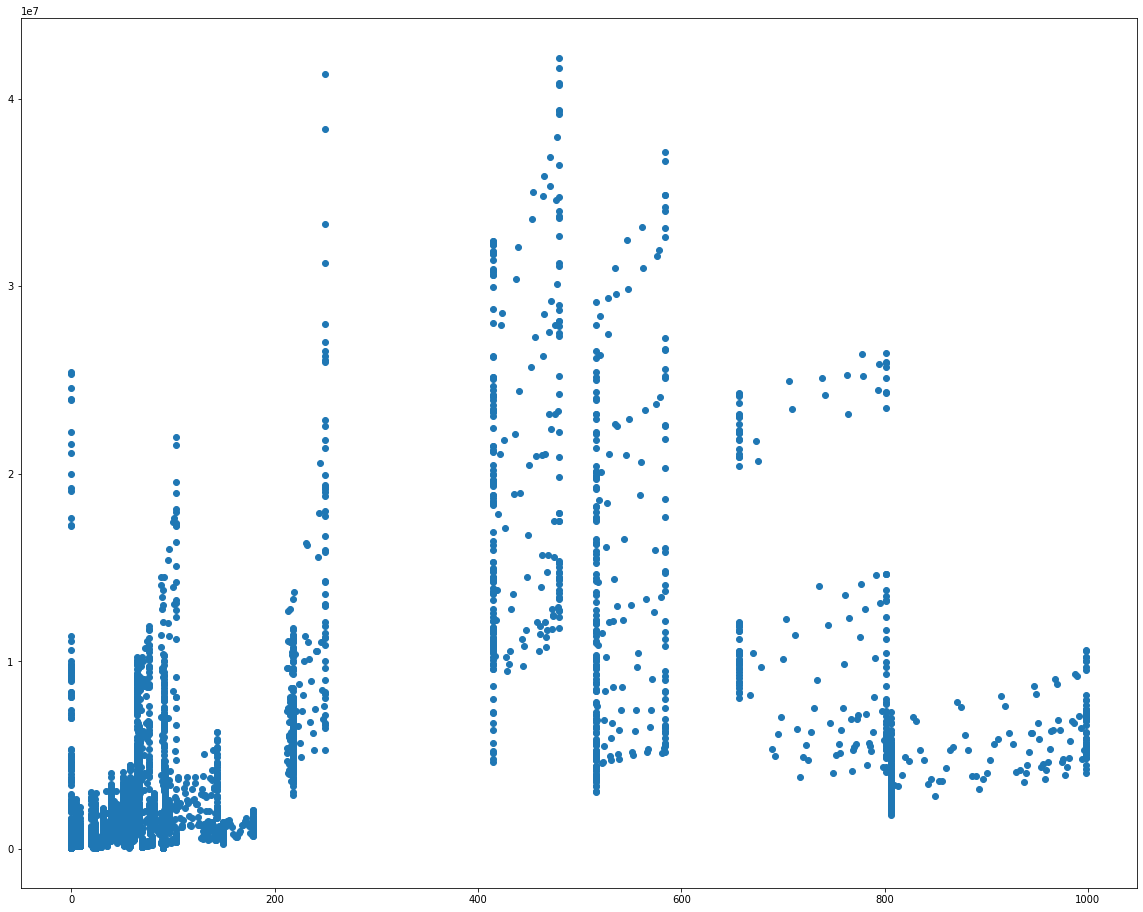

In [82]:
common_index = y.index.intersection(x.index).sort_values()
plt.scatter(x.loc[common_index, "land_cover: Square kilometre; Buildings with more than 3 floors"], y[common_index])

In [ ]:
"""
Conclusions:
    Precipitation and weather are the most important features
    If you had to choose a single feature to predit the data, "Buildings with more than 3 floors" is the best option
    Land usage features play a very significant role
    Females matter more than men
"""